<a href="https://colab.research.google.com/github/Jingut/GoingDeeper/blob/main/GD3_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#프로젝트: 자율주행 보조 시스템 만들기


In [1]:
import os, copy
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

In [2]:
import tensorflow as tf

print(tf.__version__)

2.8.2


In [3]:
!pip install Pillow==9.0.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
print(Image.__version__)

9.0.1


GPU 연결확인

In [5]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 데이터셋 불러오기


In [6]:
data_path = '/content/drive/MyDrive/aiffel/object_detection/data'

In [7]:
(ds_train, ds_val, ds_test), ds_info = tfds.load(
    'kitti',
    data_dir=data_path,
    split=['train', 'validation', 'test'],
    shuffle_files=True,
    with_info=True,
)

데이터 정보 확인

In [8]:
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/file_name': Text(shape=(), dtype=tf.string),
    'objects': Sequence({
        'alpha': tf.float32,
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
        'dimensions': Tensor(shape=(3,), dtype=tf.float32),
        'location': Tensor(shape=(3,), dtype=tf.float32),
        'occluded': ClassLabel(shape=(), dtype=tf.int64, num_classes=4),
        'rotation_y': tf.float32,
        'truncated': tf.float32,
        'type': ClassLabel(shape=(), dtype=tf.int64, num_classes=8),
    }),
})


데이터 갯수확인


In [9]:
print(tf.data.experimental.cardinality(ds_train))  
print(tf.data.experimental.cardinality(ds_val))  
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(6347, shape=(), dtype=int64)
tf.Tensor(423, shape=(), dtype=int64)
tf.Tensor(711, shape=(), dtype=int64)


클래스 개수 및 구성확인

In [10]:
NUM_CLASSES = ds_info.features["objects"]["type"].num_classes
NUM_CLASSES

8

In [11]:
TYPE_NAMES = ds_info.features["objects"]["type"].names
TYPE_NAMES

['Car',
 'Van',
 'Truck',
 'Pedestrian',
 'Person_sitting',
 'Cyclist',
 'Tram',
 'Misc']

학습데이터셋 샘플 확인

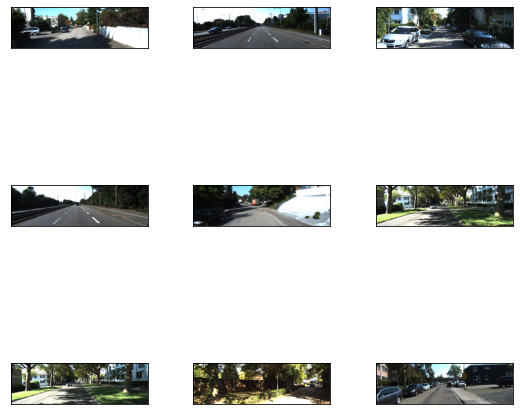

In [12]:
_ = tfds.show_examples(ds_train, ds_info)

테스트 데이터셋 샘플 확인

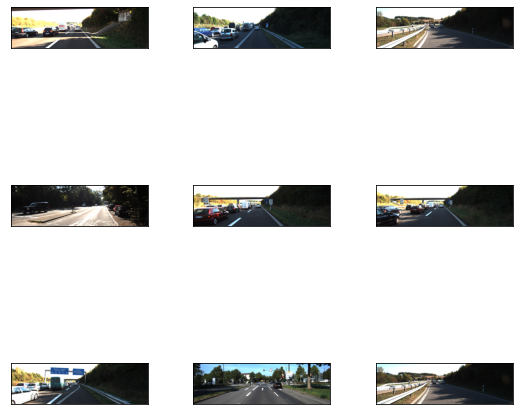

In [13]:
_ = tfds.show_examples(ds_test, ds_info)

검증용 데이터셋 샘플 확인

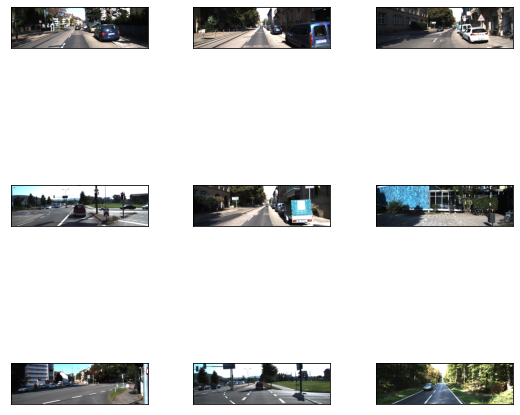

In [14]:
_ = tfds.show_examples(ds_val, ds_info)

#이미지 전처리하기

x,y 좌표 스왑

In [15]:
def swap_xy(boxes):
    return tf.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3], boxes[:, 2]], axis=-1)

무작위 플립

In [16]:
def random_flip_horizontal(image, boxes):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        boxes = tf.stack(
           [1 - boxes[:, 2], boxes[:, 1], 1 - boxes[:, 0], boxes[:, 3]], axis=-1
        )
        
    return image, boxes

In [17]:
def resize_and_pad_image(image, training=True):

    min_side = 800.0
    max_side = 1333.0
    min_side_range = [640, 1024]
    stride = 128.0
    #image_shape = tf.cast(image.size, dtype=tf.float32)
    image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)
    if training:
        min_side = tf.random.uniform((), min_side_range[0], min_side_range[1], dtype=tf.float32)
    ratio = min_side / tf.reduce_min(image_shape)
    if ratio * tf.reduce_max(image_shape) > max_side:
        ratio = max_side / tf.reduce_max(image_shape)
    image_shape = ratio * image_shape


    image = tf.image.resize(image, tf.cast(image_shape, dtype=tf.int32))
    padded_image_shape = tf.cast(
        tf.math.ceil(image_shape / stride) * stride, dtype=tf.int32
    )
    image = tf.image.pad_to_bounding_box(
        image, 0, 0, padded_image_shape[0], padded_image_shape[1]
    )
    return image, image_shape, ratio

[x_min, y_min, x_max, y_max] -> [x_min, y_min, width, height]

In [18]:
def convert_to_xywh(boxes):
    return tf.concat(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]],
        axis=-1,
    )

In [19]:
def preprocess_data(sample):
    image = sample["image"]
    bbox = swap_xy(sample["objects"]["bbox"])
    class_id = tf.cast(sample["objects"]["type"], dtype=tf.int32)

    image, bbox = random_flip_horizontal(image, bbox)
    image, image_shape, _ = resize_and_pad_image(image)

    bbox = tf.stack(
        [
            bbox[:, 0] * image_shape[1],
            bbox[:, 1] * image_shape[0],
            bbox[:, 2] * image_shape[1],
            bbox[:, 3] * image_shape[0],
        ],
        axis=-1,
    )
    bbox = convert_to_xywh(bbox)
    return image, bbox, class_id

AnchorBox 클래스

In [20]:
class AnchorBox:
    def __init__(self):
        self.aspect_ratios = [0.5, 1.0, 2.0]
        self.scales = [2 ** x for x in [0, 1 / 3, 2 / 3]]

        self._num_anchors = len(self.aspect_ratios) * len(self.scales)
        self._strides = [2 ** i for i in range(3, 8)]
        self._areas = [x ** 2 for x in [32.0, 64.0, 128.0, 256.0, 512.0]]
        self._anchor_dims = self._compute_dims()

    def _compute_dims(self):
        anchor_dims_all = []
        for area in self._areas:
            anchor_dims = []
            for ratio in self.aspect_ratios:
                anchor_height = tf.math.sqrt(area / ratio)
                anchor_width = area / anchor_height
                dims = tf.reshape(
                    tf.stack([anchor_width, anchor_height], axis=-1), [1, 1, 2]
                )
                for scale in self.scales:
                    anchor_dims.append(scale * dims)
            anchor_dims_all.append(tf.stack(anchor_dims, axis=-2))
        return anchor_dims_all

    def _get_anchors(self, feature_height, feature_width, level):
        rx = tf.range(feature_width, dtype=tf.float32) + 0.5
        ry = tf.range(feature_height, dtype=tf.float32) + 0.5
        centers = tf.stack(tf.meshgrid(rx, ry), axis=-1) * self._strides[level - 3]
        centers = tf.expand_dims(centers, axis=-2)
        centers = tf.tile(centers, [1, 1, self._num_anchors, 1])
        dims = tf.tile(
            self._anchor_dims[level - 3], [feature_height, feature_width, 1, 1]
        )
        anchors = tf.concat([centers, dims], axis=-1)
        return tf.reshape(
            anchors, [feature_height * feature_width * self._num_anchors, 4]
        )

    def get_anchors(self, image_height, image_width):
        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height / 2 ** i),
                tf.math.ceil(image_width / 2 ** i),
                i,
            )
            for i in range(3, 8)
        ]
        return tf.concat(anchors, axis=0)

In [21]:
def convert_to_corners(boxes):
    return tf.concat(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0],
        axis=-1,
    )

IoU 계산 함수

In [22]:
def compute_iou(boxes1, boxes2):
    boxes1_corners = convert_to_corners(boxes1)
    boxes2_corners = convert_to_corners(boxes2)
    lu = tf.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2])
    rd = tf.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])
    intersection = tf.maximum(0.0, rd - lu)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    boxes1_area = boxes1[:, 2] * boxes1[:, 3]
    boxes2_area = boxes2[:, 2] * boxes2[:, 3]
    union_area = tf.maximum(
        boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8
    )
    return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)

* 라벨 인코딩 클래스
라벨을 Anchor Box 에 맞추는 클래스
IoU 를 기준으로 물체에 해당하는 Anchor Box 와 배경이 되는 Anchor Box 지정 -> Anchor Box 와 실제 Bounding Box 의 차이 계산해서 상하좌우/가로세로 크기 차이를 로그로 기록



- 물체: IoU 0.5 보다 높은 경우


- 배경: IoU 0.4 보다 낮은 경우

* variance

상하좌우 차이 0.1, 가로세로 크기 차이 0.2 사용

In [23]:
class LabelEncoder:

    def __init__(self):
        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32
        )

    def _match_anchor_boxes(
        self, anchor_boxes, gt_boxes, match_iou=0.5, ignore_iou=0.4
    ):
        iou_matrix = compute_iou(anchor_boxes, gt_boxes)
        max_iou = tf.reduce_max(iou_matrix, axis=1)
        matched_gt_idx = tf.argmax(iou_matrix, axis=1)
        positive_mask = tf.greater_equal(max_iou, match_iou)
        negative_mask = tf.less(max_iou, ignore_iou)
        ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask))
        return (
            matched_gt_idx,
            tf.cast(positive_mask, dtype=tf.float32),
            tf.cast(ignore_mask, dtype=tf.float32),
        )

    def _compute_box_target(self, anchor_boxes, matched_gt_boxes):
        box_target = tf.concat(
            [
                (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
                tf.math.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:]),
            ],
            axis=-1,
        )
        box_target = box_target / self._box_variance
        return box_target

    def _encode_sample(self, image_shape, gt_boxes, cls_ids):
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        cls_ids = tf.cast(cls_ids, dtype=tf.float32)
        matched_gt_idx, positive_mask, ignore_mask = self._match_anchor_boxes(
            anchor_boxes, gt_boxes
        )
        matched_gt_boxes = tf.gather(gt_boxes, matched_gt_idx)
        box_target = self._compute_box_target(anchor_boxes, matched_gt_boxes)
        matched_gt_cls_ids = tf.gather(cls_ids, matched_gt_idx)
        cls_target = tf.where(
            tf.not_equal(positive_mask, 1.0), -1.0, matched_gt_cls_ids
        )
        cls_target = tf.where(tf.equal(ignore_mask, 1.0), -2.0, cls_target)
        cls_target = tf.expand_dims(cls_target, axis=-1)
        label = tf.concat([box_target, cls_target], axis=-1)
        return label

    def encode_batch(self, batch_images, gt_boxes, cls_ids):
        images_shape = tf.shape(batch_images)
        batch_size = images_shape[0]

        labels = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=True)
        for i in range(batch_size):
            label = self._encode_sample(images_shape, gt_boxes[i], cls_ids[i])
            labels = labels.write(i, label)
        batch_images = tf.keras.applications.resnet.preprocess_input(batch_images)
        return batch_images, labels.stack()

모델 생성

In [24]:
class FeaturePyramid(tf.keras.layers.Layer):

    def __init__(self, backbone):
        super(FeaturePyramid, self).__init__(name="FeaturePyramid")
        self.backbone = backbone
        self.conv_c3_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c4_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c5_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c3_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c4_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c5_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c6_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.conv_c7_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.upsample_2x = tf.keras.layers.UpSampling2D(2)

    def call(self, images, training=False):
        c3_output, c4_output, c5_output = self.backbone(images, training=training)
        p3_output = self.conv_c3_1x1(c3_output)
        p4_output = self.conv_c4_1x1(c4_output)
        p5_output = self.conv_c5_1x1(c5_output)
        p4_output = p4_output + self.upsample_2x(p5_output)
        p3_output = p3_output + self.upsample_2x(p4_output)
        p3_output = self.conv_c3_3x3(p3_output)
        p4_output = self.conv_c4_3x3(p4_output)
        p5_output = self.conv_c5_3x3(p5_output)
        p6_output = self.conv_c6_3x3(c5_output)
        p7_output = self.conv_c7_3x3(tf.nn.relu(p6_output))
        return p3_output, p4_output, p5_output, p6_output, p7_output

head 생성함수 

- class를 예측하는 head
- box를 예측하는 head

In [25]:
def build_head(output_filters, bias_init):
    head = tf.keras.Sequential([tf.keras.Input(shape=[None, None, 256])])
    kernel_init = tf.initializers.RandomNormal(0.0, 0.01)
    for _ in range(4):
        head.add(
            tf.keras.layers.Conv2D(256, 3, padding="same", kernel_initializer=kernel_init)
        )
        head.add(tf.keras.layers.ReLU())
    head.add(
        tf.keras.layers.Conv2D(
            output_filters,
            3,
            1,
            padding="same",
            kernel_initializer=kernel_init,
            bias_initializer=bias_init,
        )
    )
    return head

backbone

In [26]:
def get_backbone():
    backbone = tf.keras.applications.ResNet50(
        include_top=False, input_shape=[None, None, 3]
    )
    c3_output, c4_output, c5_output = [
        backbone.get_layer(layer_name).output
        for layer_name in ["conv3_block4_out", "conv4_block6_out", "conv5_block3_out"]
    ]
    return tf.keras.Model(
        inputs=[backbone.inputs], outputs=[c3_output, c4_output, c5_output]
    )

RetinaNet 클래스
Backbone + FPN + classification용 head + box용 head

In [27]:
class RetinaNet(tf.keras.Model):

    def __init__(self, num_classes, backbone):
        super(RetinaNet, self).__init__(name="RetinaNet")
        self.fpn = FeaturePyramid(backbone)
        self.num_classes = num_classes

        prior_probability = tf.constant_initializer(-np.log((1 - 0.01) / 0.01))
        self.cls_head = build_head(9 * num_classes, prior_probability)
        self.box_head = build_head(9 * 4, "zeros")

    def call(self, image, training=False):
        features = self.fpn(image, training=training)
        N = tf.shape(image)[0]
        cls_outputs = []
        box_outputs = []
        for feature in features:
            box_outputs.append(tf.reshape(self.box_head(feature), [N, -1, 4]))
            cls_outputs.append(
                tf.reshape(self.cls_head(feature), [N, -1, self.num_classes])
            )
        cls_outputs = tf.concat(cls_outputs, axis=1)
        box_outputs = tf.concat(box_outputs, axis=1)
        return tf.concat([box_outputs, cls_outputs], axis=-1)

In [28]:
class RetinaNetBoxLoss(tf.losses.Loss):

    def __init__(self, delta):
        super(RetinaNetBoxLoss, self).__init__(
            reduction="none", name="RetinaNetBoxLoss"
        )
        self._delta = delta

    def call(self, y_true, y_pred):
        difference = y_true - y_pred
        absolute_difference = tf.abs(difference)
        squared_difference = difference ** 2
        loss = tf.where(
            tf.less(absolute_difference, self._delta),
            0.5 * squared_difference,
            absolute_difference - 0.5,
        )
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetClassificationLoss(tf.losses.Loss):

    def __init__(self, alpha, gamma):
        super(RetinaNetClassificationLoss, self).__init__(
            reduction="none", name="RetinaNetClassificationLoss"
        )
        self._alpha = alpha
        self._gamma = gamma

    def call(self, y_true, y_pred):
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=y_true, logits=y_pred
        )
        probs = tf.nn.sigmoid(y_pred)
        alpha = tf.where(tf.equal(y_true, 1.0), self._alpha, (1.0 - self._alpha))
        pt = tf.where(tf.equal(y_true, 1.0), probs, 1 - probs)
        loss = alpha * tf.pow(1.0 - pt, self._gamma) * cross_entropy
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetLoss(tf.losses.Loss):

    def __init__(self, alpha, gamma):
        super(RetinaNetClassificationLoss, self).__init__(
            reduction="none", name="RetinaNetClassificationLoss"
        )
        self._alpha = alpha
        self._gamma = gamma

    def call(self, y_true, y_pred):
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=y_true, logits=y_pred
        )
        probs = tf.nn.sigmoid(y_pred)
        alpha = tf.where(tf.equal(y_true, 1.0), self._alpha, (1.0 - self._alpha))
        pt = tf.where(tf.equal(y_true, 1.0), probs, 1 - probs)
        loss = alpha * tf.pow(1.0 - pt, self._gamma) * cross_entropy
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetLoss(tf.losses.Loss):

    def __init__(self, num_classes=8, alpha=0.25, gamma=2.0, delta=1.0):
        super(RetinaNetLoss, self).__init__(reduction="auto", name="RetinaNetLoss")
        self._clf_loss = RetinaNetClassificationLoss(alpha, gamma)
        self._box_loss = RetinaNetBoxLoss(delta)
        self._num_classes = num_classes

    def call(self, y_true, y_pred):
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        box_labels = y_true[:, :, :4]
        box_predictions = y_pred[:, :, :4]
        cls_labels = tf.one_hot(
            tf.cast(y_true[:, :, 4], dtype=tf.int32),
            depth=self._num_classes,
            dtype=tf.float32,
        )
        cls_predictions = y_pred[:, :, 4:]
        positive_mask = tf.cast(tf.greater(y_true[:, :, 4], -1.0), dtype=tf.float32)
        ignore_mask = tf.cast(tf.equal(y_true[:, :, 4], -2.0), dtype=tf.float32)
        clf_loss = self._clf_loss(cls_labels, cls_predictions)
        box_loss = self._box_loss(box_labels, box_predictions)
        clf_loss = tf.where(tf.equal(ignore_mask, 1.0), 0.0, clf_loss)
        box_loss = tf.where(tf.equal(positive_mask, 1.0), box_loss, 0.0)
        normalizer = tf.reduce_sum(positive_mask, axis=-1)
        clf_loss = tf.math.divide_no_nan(tf.reduce_sum(clf_loss, axis=-1), normalizer)
        box_loss = tf.math.divide_no_nan(tf.reduce_sum(box_loss, axis=-1), normalizer)
        loss = clf_loss + box_loss
        return loss

#모델학습

In [29]:
BATCH_SIZE = 2
NUM_CLASSES = 8

In [30]:
resnet50_backbone = get_backbone()
loss_fn = RetinaNetLoss(NUM_CLASSES)
model = RetinaNet(NUM_CLASSES, resnet50_backbone)

In [31]:
learning_rates = [2.5e-06, 0.000625, 0.00125, 0.0025, 0.00025, 2.5e-05]
learning_rate_boundaries = [125, 250, 500, 240000, 360000]
learning_rate_fn = tf.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=learning_rate_boundaries, values=learning_rates
)
optimizer = tf.optimizers.SGD(learning_rate=learning_rate_fn, momentum=0.9)
model.compile(loss=loss_fn, optimizer=optimizer, metrics=['accuracy'])

파이프라인 생성

In [32]:
label_encoder = LabelEncoder()

autotune = tf.data.AUTOTUNE
ds_train = ds_train.map(preprocess_data, num_parallel_calls=autotune)
ds_train = ds_train.shuffle(8 * BATCH_SIZE)
ds_train = ds_train.padded_batch(
    batch_size=BATCH_SIZE, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
ds_train = ds_train.map(
    label_encoder.encode_batch, num_parallel_calls=autotune
)
ds_train = ds_train.prefetch(autotune)

ds_val = ds_val.map(preprocess_data, num_parallel_calls=autotune)
ds_val = ds_val.padded_batch(
    batch_size=1, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
ds_val = ds_val.map(label_encoder.encode_batch, num_parallel_calls=autotune)
ds_val = ds_val.prefetch(autotune)

In [33]:
# MODEL_DIR = os.path.join(data_path, 'checkpoints')
# MODEL_PATH = os.path.join(MODEL_DIR, f'weights_epoch_{EPOCHS}')
# EPOCHS = 1

In [34]:
# def model_fit(model, model_path):
#     callbacks_list = [
#         # 훈련 중간중간 현재 parameter 값 저장
#         tf.keras.callbacks.ModelCheckpoint(
#             filepath=model_path,
#             monitor="val_loss",
#             save_best_only=False,
#             save_weights_only=True,
#             verbose=1,
#         ),

#         # 너무 일찍 학습이 끝나버려서 사용안함  EPOCHS=15 로 진행
#         # early_stopping
#         # tf.keras.callbacks.EarlyStopping(
#         #     monitor='val_loss', patience=3
#         # ),
#     ]

#     history = model.fit(
#         ds_train,
#         validation_data=ds_val,
#         epochs=EPOCHS,
#         callbacks=callbacks_list
#     )

#     return history

In [35]:
model_dir = '/content/drive/MyDrive/aiffel/object_detection/data/checkpoint'
latest_checkpoint = tf.train.latest_checkpoint(model_dir)
model.load_weights(latest_checkpoint)

#결과확인

In [36]:
class DecodePredictions(tf.keras.layers.Layer):

    def __init__(
        self,
        num_classes=8,
        confidence_threshold=0.05,
        nms_iou_threshold=0.5,
        max_detections_per_class=100,
        max_detections=100,
        box_variance=[0.1, 0.1, 0.2, 0.2]
    ):
        super(DecodePredictions, self).__init__()
        self.num_classes = num_classes
        self.confidence_threshold = confidence_threshold
        self.nms_iou_threshold = nms_iou_threshold
        self.max_detections_per_class = max_detections_per_class
        self.max_detections = max_detections

        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            box_variance, dtype=tf.float32
        )

    def _decode_box_predictions(self, anchor_boxes, box_predictions):
        boxes = box_predictions * self._box_variance
        boxes = tf.concat(
            [
                boxes[:, :, :2] * anchor_boxes[:, :, 2:] + anchor_boxes[:, :, :2],
                tf.math.exp(boxes[:, :, 2:]) * anchor_boxes[:, :, 2:],
            ],
            axis=-1,
        )
        boxes_transformed = convert_to_corners(boxes)
        return boxes_transformed

    def call(self, images, predictions):
        image_shape = tf.cast(tf.shape(images), dtype=tf.float32)
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        box_predictions = predictions[:, :, :4]
        cls_predictions = tf.nn.sigmoid(predictions[:, :, 4:])
        boxes = self._decode_box_predictions(anchor_boxes[None, ...], box_predictions)

        return tf.image.combined_non_max_suppression(
            tf.expand_dims(boxes, axis=2),
            cls_predictions,
            self.max_detections_per_class,
            self.max_detections,
            self.nms_iou_threshold,
            self.confidence_threshold,
            clip_boxes=False,
        )

In [37]:
image = tf.keras.Input(shape=[None, None, 3], name="image")
predictions = model(image, training=False)
detections = DecodePredictions(confidence_threshold=0.5)(image, predictions)
inference_model = tf.keras.Model(inputs=image, outputs=detections)

In [38]:
def visualize_detections(
    image, boxes, classes, scores, figsize=(7, 7), linewidth=1, color=[0, 0, 1]
):
    image = np.array(image, dtype=np.uint8)
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    for box, _cls, score in zip(boxes, classes, scores):
        text = "{}: {:.2f}".format(_cls, score)
        x1, y1, x2, y2 = box
        origin_x, origin_y = x1, image.shape[0] - y2 # matplitlib에서 Rectangle와 text를 그릴 때는 좌하단이 원점이고 위로 갈 수록 y값이 커집니다
        w, h = x2 - x1, y2 - y1
        patch = plt.Rectangle(
            [origin_x, origin_y], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        ax.text(
            origin_x,
            origin_y,
            text,
            bbox={"facecolor": color, "alpha": 0.4},
            clip_box=ax.clipbox,
            clip_on=True,
        )
    plt.show()
    return ax

In [39]:
def visualize_detections2(
    image, boxes, classes):
  
    image = np.array(image, dtype=np.uint8)
    result = 'Go'
    for box, _cls in zip(boxes, classes):
      x1, y1, x2, y2 = box
      w, h = x2 - x1, y2 - y1

      print(box, _cls)

      if _cls in ['Pedestrian', 'Person_sitting']:
        result = 'Stop'
        

      elif _cls in ['Car','Van','Truck','Cyclist','Tram']:
        if w >= 300 or h >= 300: 
          result = 'Stop'

    return result

In [40]:
def prepare_image(image):
    image, _, ratio = resize_and_pad_image(image, training=False)
    image = tf.keras.applications.resnet.preprocess_input(image)
    return tf.expand_dims(image, axis=0), ratio

object detection 시각화

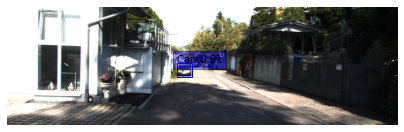

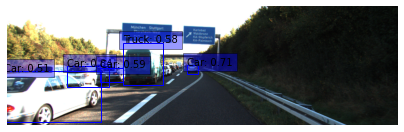

In [41]:
test_dataset = tfds.load("kitti", split="test", data_dir=data_path)
int2str = ds_info.features["objects"]["type"].int2str

for sample in test_dataset.take(2):
    image = tf.cast(sample["image"], dtype=tf.float32)
    input_image, ratio = prepare_image(image)
    detections = inference_model.predict(input_image)
    num_detections = detections.valid_detections[0]
    class_names = [
        int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]
    ]
    visualize_detections(
        image,
        detections.nmsed_boxes[0][:num_detections] / ratio,
        class_names,
        detections.nmsed_scores[0][:num_detections],
    )

##1. 자율주행 시스템 만들기

위에서 만든 모델을 통해 아래의 조건을 만족하는 함수를 만들어 주세요.

입력으로 이미지 경로를 받습니다.

정지조건에 맞는 경우 "Stop" 아닌 경우 "Go"를 반환합니다.

* 조건은 다음과 같습니다.

- 사람이 한 명 이상 있는 경우
- 차량의 크기(width or height)가 300px이상인 경우

In [42]:
img_path = '/content/drive/MyDrive/aiffel/object_detection/data/go_1.png'

def self_drive_assist(img_path):

  #image = tf.io.read_file(img_path)

  #image = Image.open(img_path)

  #image = tf.io.decode_image(image, channels = 3, dtype=tf.dtypes.float32)
    
  image = tf.keras.utils.load_img(img_path)

  #image = tf.convert_to_tensor(image, dtype=tf.float32)

  input_image, ratio = prepare_image(image)

  detections = inference_model.predict(input_image)

  num_detections = detections.valid_detections[0]

  class_names = [int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]]

  Go_Stop = visualize_detections2(
    image,
    detections.nmsed_boxes[0][:num_detections] / ratio,
    class_names)

  
  return Go_Stop

print(self_drive_assist(img_path))

tf.Tensor([592.4973  169.42628 626.708   198.10838], shape=(4,), dtype=float32) Car
tf.Tensor([375.57803 165.27217 417.32632 188.0812 ], shape=(4,), dtype=float32) Car
tf.Tensor([197.00189 146.51572 364.6052  248.32855], shape=(4,), dtype=float32) Truck
Go


##2. 자율주행 시스템 평가하기
아래 test_system() 를 통해서 위에서 만든 함수를 평가해봅시다. 10장에 대해 Go와 Stop을 맞게 반환하는지 확인하고 100점 만점으로 평가해줍니다.

In [43]:
import os

def test_system(func):
    work_dir = '/content/drive/MyDrive/aiffel/object_detection/data'
    score = 0
    test_set=[
        ("stop_1.png", "Stop"),
        ("stop_2.png", "Stop"),
        ("stop_3.png", "Stop"),
        ("stop_4.png", "Stop"),
        ("stop_5.png", "Stop"),
        ("go_1.png", "Go"),
        ("go_2.png", "Go"),
        ("go_3.png", "Go"),
        ("go_4.png", "Go"),
        ("go_5.png", "Go"),
    ]
    
    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        pred = func(image_path)
        if pred == answer:
            score += 10
        print(pred, answer)    
    print(f"{score}점입니다.")

test_system(self_drive_assist)

tf.Tensor([780.4891    60.639492 849.3004   215.28815 ], shape=(4,), dtype=float32) Pedestrian
Stop Stop
tf.Tensor([423.5013    46.657364 496.3302   206.24571 ], shape=(4,), dtype=float32) Pedestrian
Stop Stop
tf.Tensor([ -6.632939   -0.6097548 306.63806   162.56013  ], shape=(4,), dtype=float32) Car
tf.Tensor([762.4521  161.98457 883.05566 202.10532], shape=(4,), dtype=float32) Car
Stop Stop
tf.Tensor([361.67245 154.6089  494.76608 197.68105], shape=(4,), dtype=float32) Car
tf.Tensor([111.353745  80.7489   371.46915  205.93707 ], shape=(4,), dtype=float32) Car
tf.Tensor([701.8741   110.385704 813.1373   189.73157 ], shape=(4,), dtype=float32) Car
tf.Tensor([656.81305 155.57013 737.835   230.9217 ], shape=(4,), dtype=float32) Van
tf.Tensor([405.07104 161.31653 529.73596 204.1998 ], shape=(4,), dtype=float32) Car
Go Stop
tf.Tensor([566.15686 160.32376 619.01825 192.00706], shape=(4,), dtype=float32) Car
tf.Tensor([744.3864  132.28186 858.3431  203.33064], shape=(4,), dtype=float32) Car


#결론
이번 프로젝트에서는 KITTI 데이터셋 을 가공하여RetinaNet으로 자율주행 시스템을 만들어보았습니다.

5개의 보행자나 사람이 없는 Go 이미지와 보행자나 사람이 있는 Stop이미지 5장으로 성능을 테스트 해보았습니다.

평가 결과 90점으로 나왔고 하나 틀린 pred는 Stop 이미지에서 보행자를 인식하지 못하여 Go 이미지로 잘못 예측한 결과가 나왔습니다.


# 회고

---



## - 이번 프로젝트에서 어려웠던 점
자율주행을 위해 함수를 구현하는 부분이 많이 어려웠고 마지막에 이미지를 로드하는 부분에서 Pillow 버전을 9.0.2로 맞춰 주지 않아 오류가 난 부분을 찾는데에 많은 시간을 소비했습니다.

---


## - 프로젝트를 진행하면서 알게된 점
라이브러리 버전을 맞춰주거나 상위의 버전을 맞춰주어야 오류가 안났습니다.


---


## - 루브릭 평가지표를 맞추기 위해 시도한 것들
정확한 object detection을 하기 위해 visualize_detections2 를 구현하였습니다.

데이터의 필요한 클래스 이름들을 알기 위해 데이터 분석을 진행하였습니다.

---


## - 자기다짐
시작전에 라이브러리 버전을 꼼꼼히 확인하자...
